Epoch 1/50 - Loss: 6.4476
Epoch 2/50 - Loss: 0.8993
Epoch 3/50 - Loss: 0.6745
Epoch 4/50 - Loss: 0.5734
Epoch 5/50 - Loss: 0.5185
Epoch 6/50 - Loss: 0.4759
Epoch 7/50 - Loss: 0.4593
Epoch 8/50 - Loss: 0.4307
Epoch 9/50 - Loss: 0.4152
Epoch 10/50 - Loss: 0.4025
Epoch 11/50 - Loss: 0.3896
Epoch 12/50 - Loss: 0.3795
Epoch 13/50 - Loss: 0.3713
Epoch 14/50 - Loss: 0.3659
Epoch 15/50 - Loss: 0.3549
Epoch 16/50 - Loss: 0.3480
Epoch 17/50 - Loss: 0.3431
Epoch 18/50 - Loss: 0.3350
Epoch 19/50 - Loss: 0.3330
Epoch 20/50 - Loss: 0.3242
Epoch 21/50 - Loss: 0.3209
Epoch 22/50 - Loss: 0.3224
Epoch 23/50 - Loss: 0.3116
Epoch 24/50 - Loss: 0.3104
Epoch 25/50 - Loss: 0.3075
Epoch 26/50 - Loss: 0.3052
Epoch 27/50 - Loss: 0.3021
Epoch 28/50 - Loss: 0.3005
Epoch 29/50 - Loss: 0.2971
Epoch 30/50 - Loss: 0.2948
Epoch 31/50 - Loss: 0.2914
Epoch 32/50 - Loss: 0.2902
Epoch 33/50 - Loss: 0.2875
Epoch 34/50 - Loss: 0.2887
Epoch 35/50 - Loss: 0.2816
Epoch 36/50 - Loss: 0.2831
Epoch 37/50 - Loss: 0.2795
Epoch 38/5

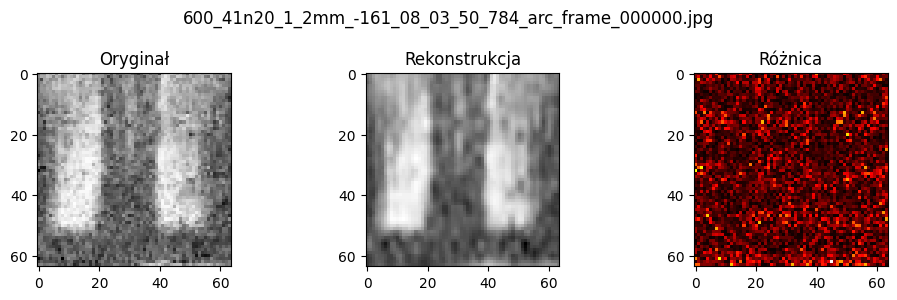

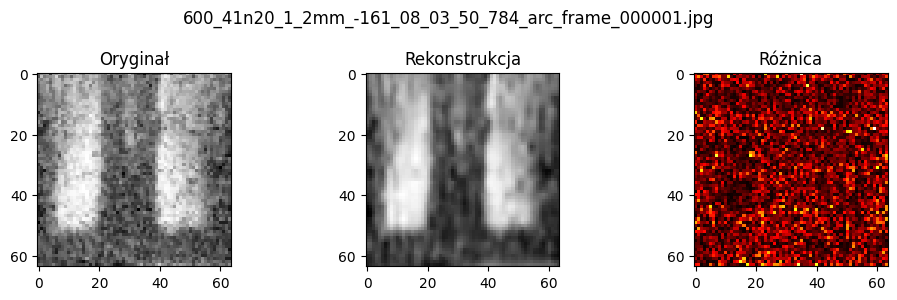

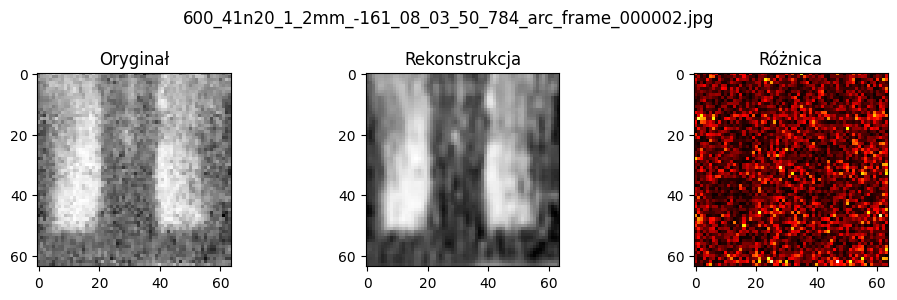

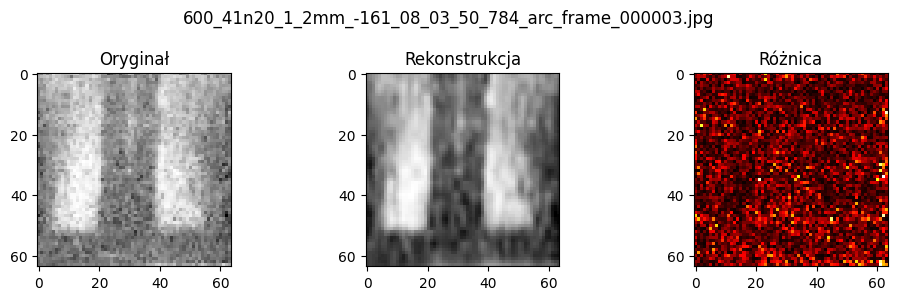

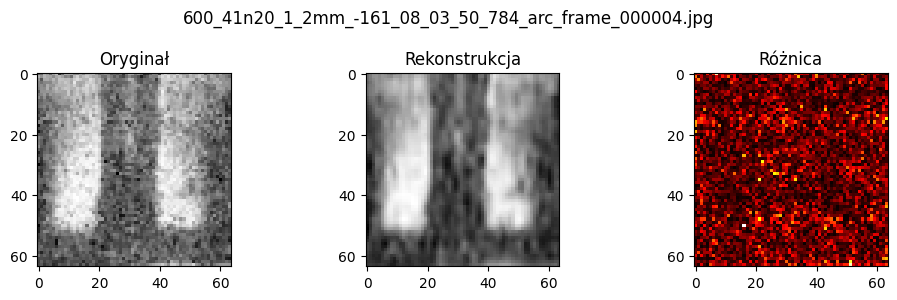

In [1]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# === KONFIGURACJA ===
# IMAGE_DIR = "output_rois/train_roi_weld"
IMAGE_DIR = "output_rois/train_roi_arc"  # Ścieżka do katalogu z obrazami
MODEL_SAVE_PATH = "arc_autoencoder.pth"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === TRANSFORMACJE ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # Zakres [0, 1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# === AUTOENCODER ===
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRENING ===
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        recon = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")

# === ZAPIS MODELU ===
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Model zapisano do: {MODEL_SAVE_PATH}")

# === PODGLĄD REKONSTRUKCJI ===
model.eval()
with torch.no_grad():
    for i in range(5):  # przykładowe 5 obrazów
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()

        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(fname)
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()


Epoch 1/50 - Loss: 2.4173
Epoch 2/50 - Loss: 0.4228
Epoch 3/50 - Loss: 0.1529
Epoch 4/50 - Loss: 0.0997
Epoch 5/50 - Loss: 0.0796
Epoch 6/50 - Loss: 0.0712
Epoch 7/50 - Loss: 0.0655
Epoch 8/50 - Loss: 0.0598
Epoch 9/50 - Loss: 0.0554
Epoch 10/50 - Loss: 0.0517
Epoch 11/50 - Loss: 0.0492
Epoch 12/50 - Loss: 0.0457
Epoch 13/50 - Loss: 0.0438
Epoch 14/50 - Loss: 0.0432
Epoch 15/50 - Loss: 0.0418
Epoch 16/50 - Loss: 0.0394
Epoch 17/50 - Loss: 0.0386
Epoch 18/50 - Loss: 0.0382
Epoch 19/50 - Loss: 0.0375
Epoch 20/50 - Loss: 0.0354
Epoch 21/50 - Loss: 0.0347
Epoch 22/50 - Loss: 0.0339
Epoch 23/50 - Loss: 0.0331
Epoch 24/50 - Loss: 0.0346
Epoch 25/50 - Loss: 0.0314
Epoch 26/50 - Loss: 0.0305
Epoch 27/50 - Loss: 0.0298
Epoch 28/50 - Loss: 0.0305
Epoch 29/50 - Loss: 0.0280
Epoch 30/50 - Loss: 0.0272
Epoch 31/50 - Loss: 0.0272
Epoch 32/50 - Loss: 0.0269
Epoch 33/50 - Loss: 0.0258
Epoch 34/50 - Loss: 0.0253
Epoch 35/50 - Loss: 0.0249
Epoch 36/50 - Loss: 0.0242
Epoch 37/50 - Loss: 0.0237
Epoch 38/5

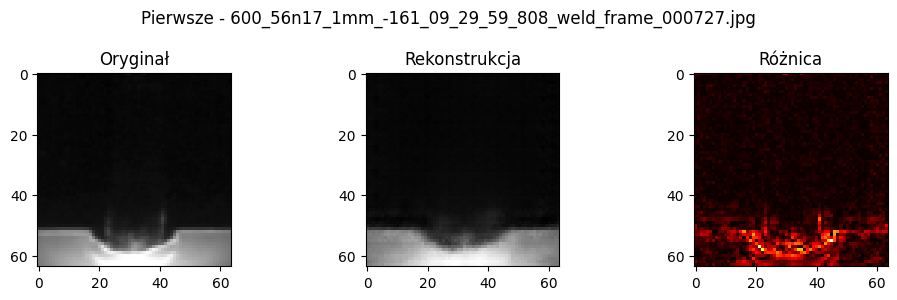

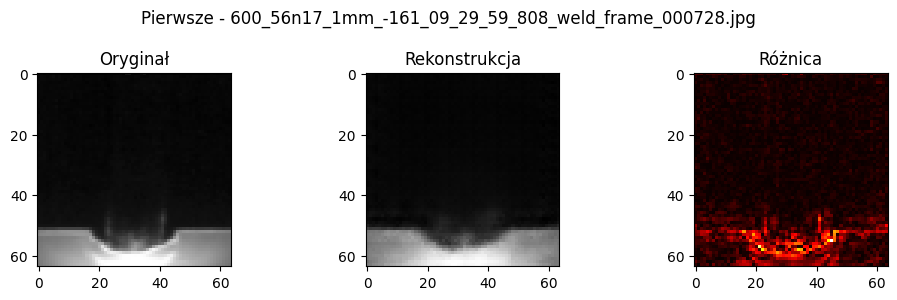

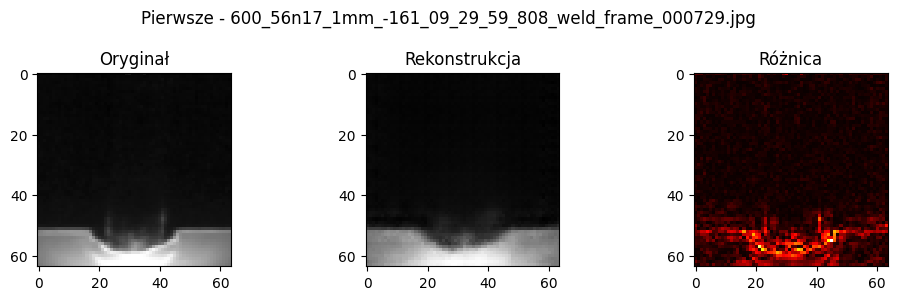

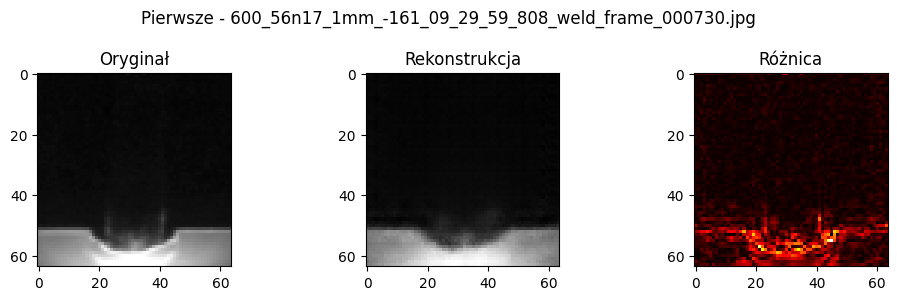

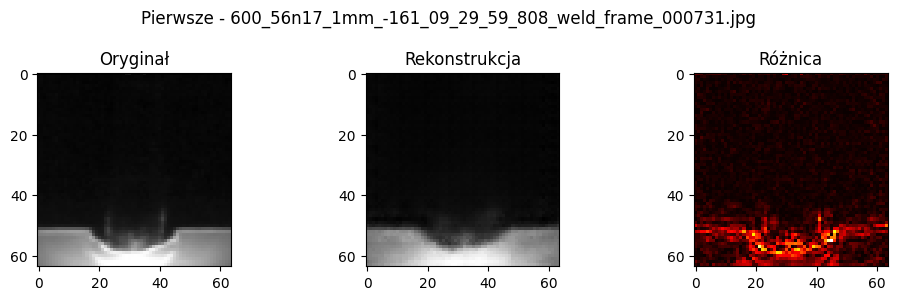

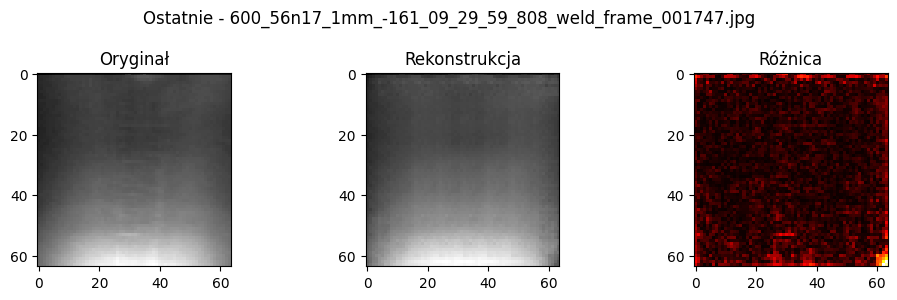

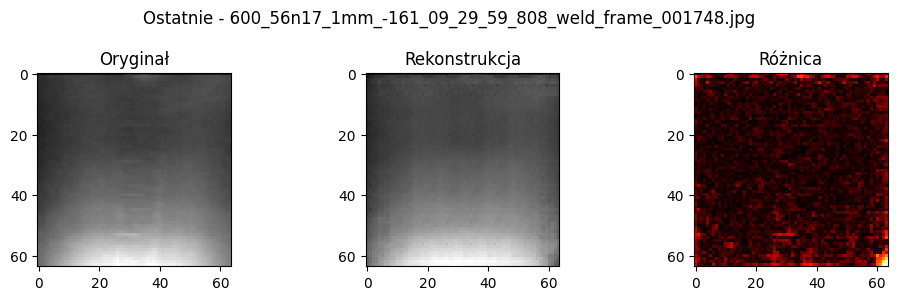

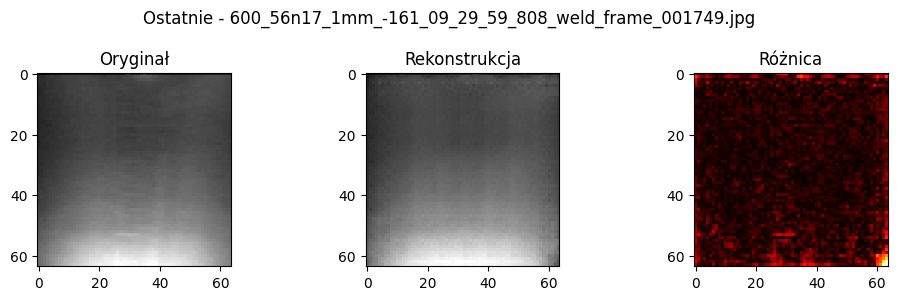

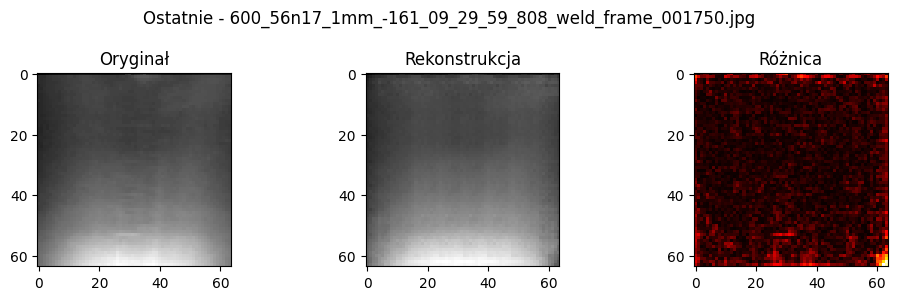

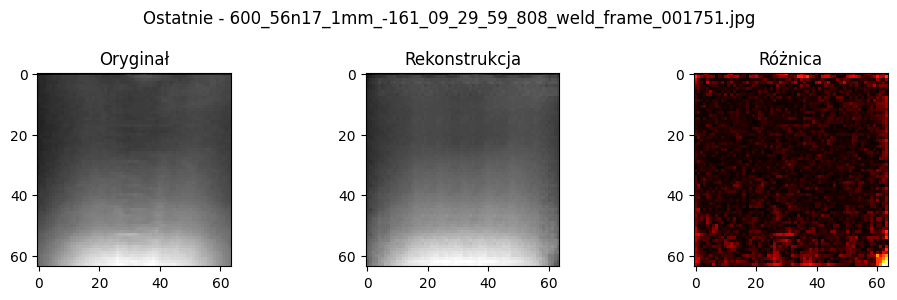

In [2]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# === KONFIGURACJA ===
IMAGE_DIR = "output_rois/train_roi_weld"
# IMAGE_DIR = "output_rois/train_roi_arc"  # Ścieżka do katalogu z obrazami
MODEL_SAVE_PATH = "./models/weld_autoencoder.pth"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === TRANSFORMACJE ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # Zakres [0, 1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# === AUTOENCODER ===
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRENING ===
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        recon = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")

# === ZAPIS MODELU ===
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Model zapisano do: {MODEL_SAVE_PATH}")

# === PODGLĄD REKONSTRUKCJI ===
model.eval()
with torch.no_grad():
    # Pierwsze 5 obrazów
    for i in range(5):
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()
        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Pierwsze - {fname}")
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()

    # Ostatnie 5 obrazów
    dataset_len = len(dataset)
    for i in range(dataset_len - 5, dataset_len):
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()
        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Ostatnie - {fname}")
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()


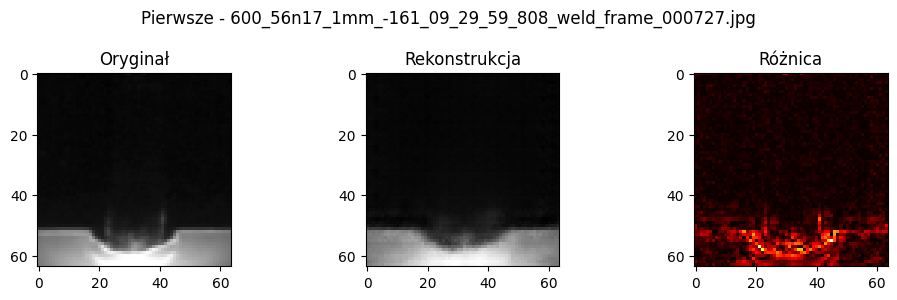

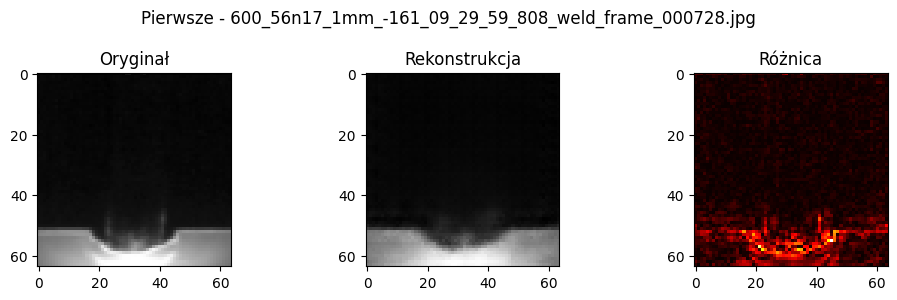

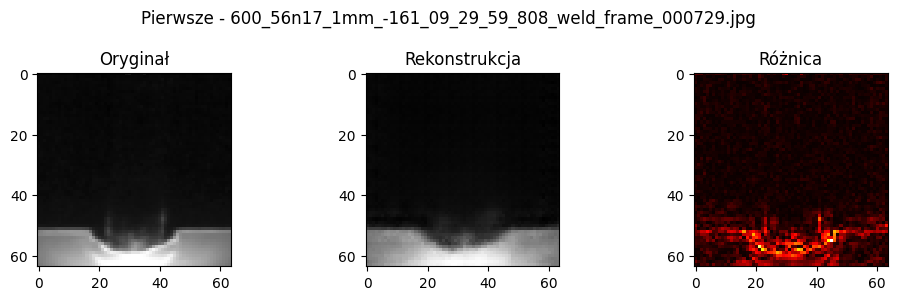

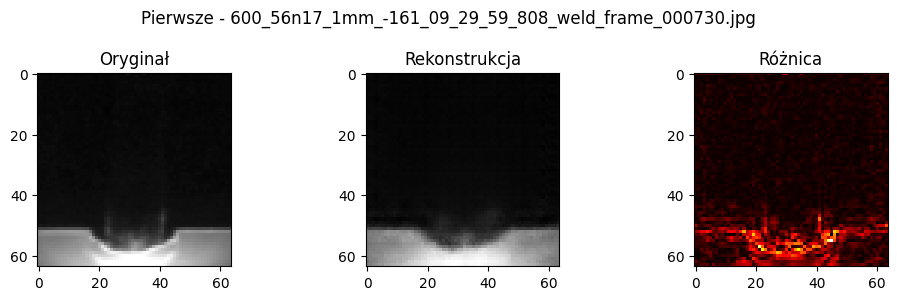

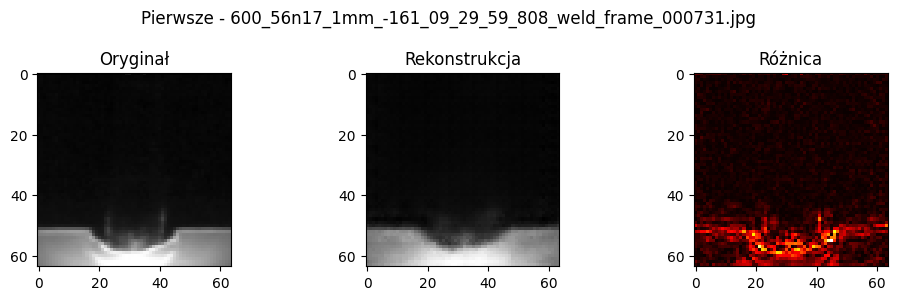

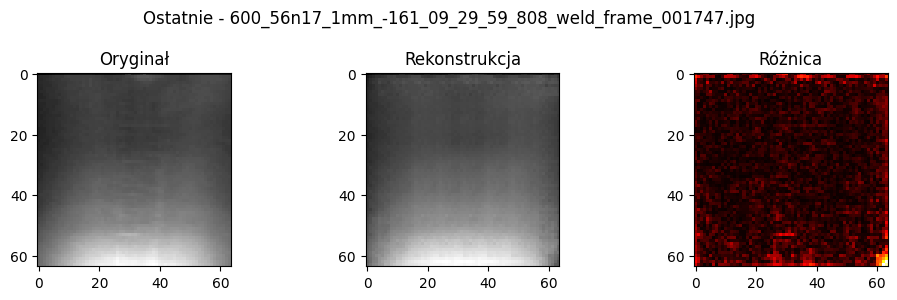

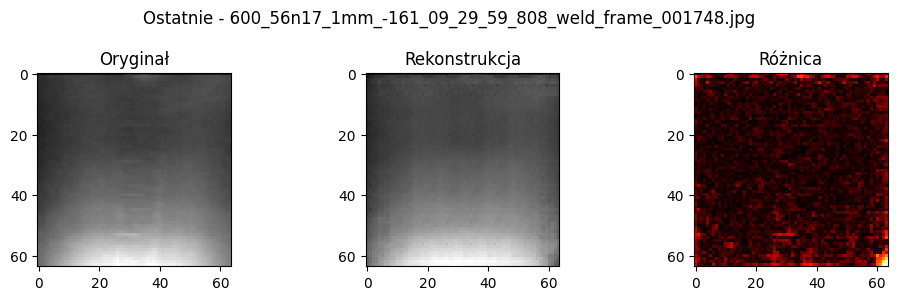

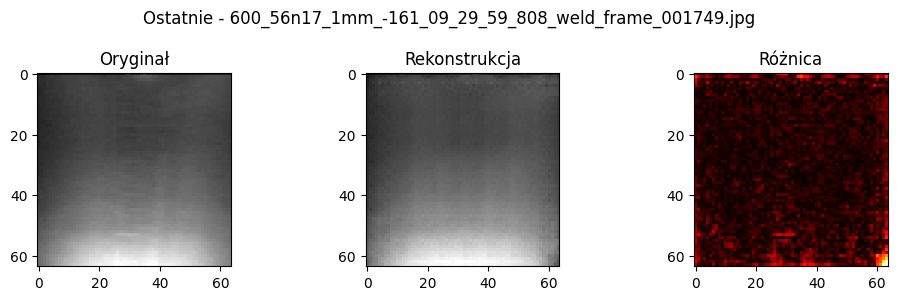

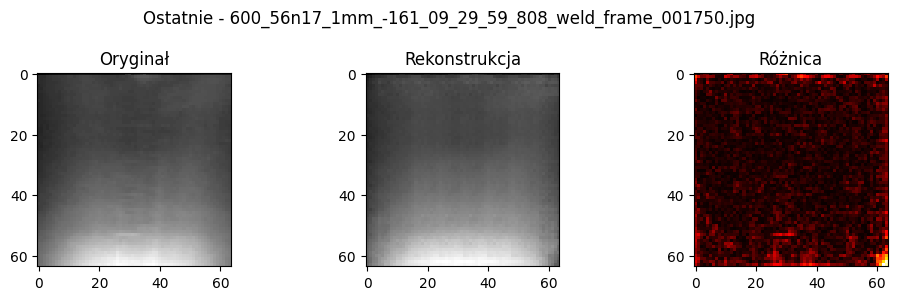

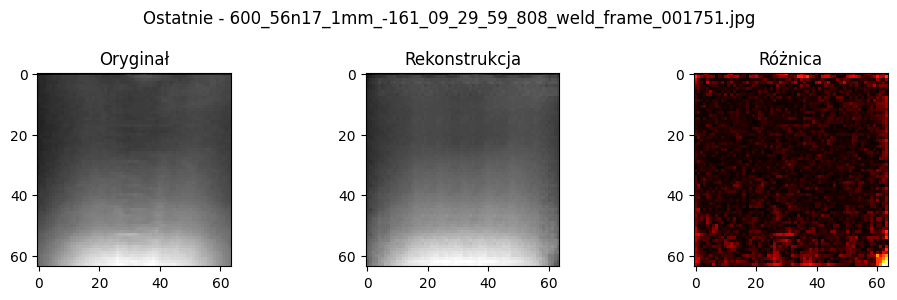

In [3]:
# === PODGLĄD REKONSTRUKCJI ===
model.eval()
with torch.no_grad():
    # Pierwsze 5 obrazów
    for i in range(5):
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()
        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Pierwsze - {fname}")
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()

    # Ostatnie 5 obrazów
    dataset_len = len(dataset)
    for i in range(dataset_len - 5, dataset_len):
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()
        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Ostatnie - {fname}")
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()